In [ ]:
# Install required packages
!pip install lightgbm mlflow dagshub pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# Step 1: Import necessary libraries
# -------------------------------------------------------------
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import joblib
import mlflow
import mlflow.sklearn
import yaml
import os
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

sns.set(style="whitegrid")
print("✅ Libraries imported.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/

In [ ]:
# Load data from GitHub
print("📥 Loading data from GitHub...")

training_url = "https://raw.githubusercontent.com/jkhan2211/DiseaseFeatureClassifiers/feature/jk-changes/data/Training.csv"
testing_url = "https://raw.githubusercontent.com/jkhan2211/DiseaseFeatureClassifiers/feature/jk-changes/data/Testing.csv"

df_train = pd.read_csv(training_url)
df_test = pd.read_csv(testing_url)

# Remove any unnamed columns
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]

print(f"Training shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")


📥 Loading data from GitHub...
Training shape: (4187, 133)
Test shape: (775, 133)


EDA: Train Data

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4187 entries, 0 to 4186
Columns: 133 entries, itching to SymptomGroup
dtypes: int64(132), object(1)
memory usage: 4.2+ MB


In [ ]:
df_train['prognosis'].describe()

,prognosis
count,4187
unique,41
top,(vertigo) Paroymsal Positional Vertigo
freq,115


In [ ]:
duplicate_columns_train = df_train.columns[df_train.columns.duplicated()]
print(f'Duplicate column names: {duplicate_columns_train.tolist()}')

Duplicate column names: []


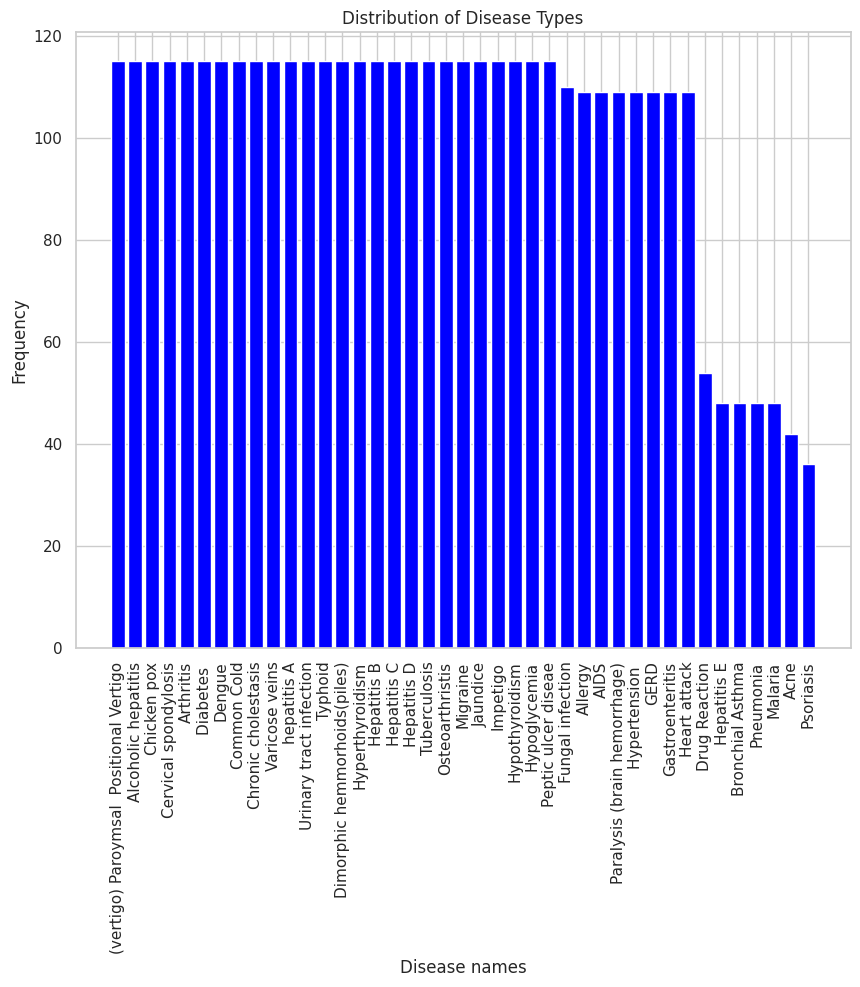

In [ ]:
names = df_train['prognosis'].value_counts().keys()
counts = df_train['prognosis'].value_counts().values
plt.subplots(figsize=(10, 8))
plt.bar(names, counts, color='blue')

plt.xlabel('Disease names')
plt.ylabel('Frequency')
plt.title('Distribution of Disease Types')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_train.shape

(4187, 133)

In [ ]:
import matplotlib.pyplot as plt

missing = df_train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if not missing.empty:
    missing.plot.bar()
    plt.title('Missing Data')
    plt.show()
else:
    print("✅ No missing data found in the dataset.")


✅ No missing data found in the dataset.


In [ ]:
def prep_data(train_df, test_df):
  # Prepare features and target
  X_train = df_train.drop('prognosis', axis=1)
  y_train = df_train['prognosis']
  X_test = df_test.drop('prognosis', axis=1)
  y_test = df_test['prognosis']

  # Encode target labels
  label_encoder = LabelEncoder()
  y_train_encoded = label_encoder.fit_transform(y_train)
  y_test_encoded = label_encoder.transform(y_test)

  print(f"Number of classes: {len(label_encoder.classes_)}")
  print(f"Classes: {label_encoder.classes_}")

  return X_train, X_test, y_train_encoded, y_test_encoded, label_encoder
X_train, X_test, y_train, y_test, label_encoder = prep_data(df_train, df_test)


Number of classes: 41
Classes: ['(vertigo) Paroymsal  Positional Vertigo' 'AIDS' 'Acne'
 'Alcoholic hepatitis' 'Allergy' 'Arthritis' 'Bronchial Asthma'
 'Cervical spondylosis' 'Chicken pox' 'Chronic cholestasis' 'Common Cold'
 'Dengue' 'Diabetes ' 'Dimorphic hemmorhoids(piles)' 'Drug Reaction'
 'Fungal infection' 'GERD' 'Gastroenteritis' 'Heart attack' 'Hepatitis B'
 'Hepatitis C' 'Hepatitis D' 'Hepatitis E' 'Hypertension '
 'Hyperthyroidism' 'Hypoglycemia' 'Hypothyroidism' 'Impetigo' 'Jaundice'
 'Malaria' 'Migraine' 'Osteoarthristis' 'Paralysis (brain hemorrhage)'
 'Peptic ulcer diseae' 'Pneumonia' 'Psoriasis' 'Tuberculosis' 'Typhoid'
 'Urinary tract infection' 'Varicose veins' 'hepatitis A']


In [ ]:
# Quick baseline
print(" Training LightGBM Baseline...")

# Simple model with default parameters
lgb_baseline = lgb.LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1  # Use all Colab CPU cores
)

lgb_baseline.fit(X_train, y_train)
y_pred = lgb_baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Baseline Accuracy: {accuracy:.4f}")

# Feature importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
print(importance.head(10))

 Training LightGBM Baseline...
✅ Baseline Accuracy: 0.9303

🔍 Top 10 Most Important Features:
                       feature  importance
131               SymptomGroup       19412
33                  dark_urine        1740
105             family_history        1511
80                  stiff_neck        1510
99                  belly_pain        1469
19                 weight_loss        1449
102         watering_from_eyes        1417
86   weakness_of_one_body_side        1415
109        visual_disturbances        1352
93         toxic_look_(typhos)        1300


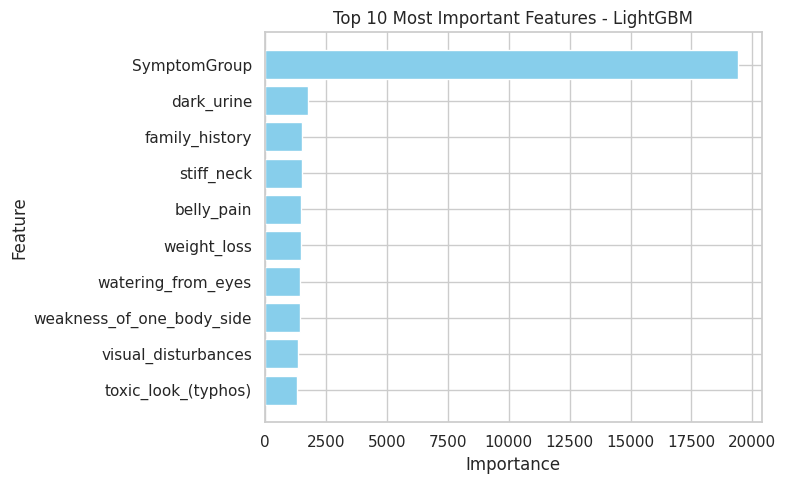

In [ ]:
import matplotlib.pyplot as plt

top_features = importance.sort_values(by='importance', ascending=True).tail(10)

plt.figure(figsize=(8, 5))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.title('Top 10 Most Important Features - LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


**Advanced LightGBM Optimization
Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train_encoded, y_test_encoded, label_encoder = prep_data(df_train, df_test)


print("Starting Hyperparameter Tuning...")
# train
# Define parameter grid
# From common course examples
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [3, 5, 7, -1],
    'min_data_in_leaf': [20, 50, 100],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'class_weight': ['balanced', None]  # Handle class imbalance
}

lgb_tuner = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

lgb_tuner.fit(X_train, y_train)
y_pred = lgb_tuner.predict(X_test)
y_pred_proba = lgb_tuner.predict_proba(X_test)

# Cell 5: Standard metrics reporting
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Number of classes: 41
Classes: ['(vertigo) Paroymsal  Positional Vertigo' 'AIDS' 'Acne'
 'Alcoholic hepatitis' 'Allergy' 'Arthritis' 'Bronchial Asthma'
 'Cervical spondylosis' 'Chicken pox' 'Chronic cholestasis' 'Common Cold'
 'Dengue' 'Diabetes ' 'Dimorphic hemmorhoids(piles)' 'Drug Reaction'
 'Fungal infection' 'GERD' 'Gastroenteritis' 'Heart attack' 'Hepatitis B'
 'Hepatitis C' 'Hepatitis D' 'Hepatitis E' 'Hypertension '
 'Hyperthyroidism' 'Hypoglycemia' 'Hypothyroidism' 'Impetigo' 'Jaundice'
 'Malaria' 'Migraine' 'Osteoarthristis' 'Paralysis (brain hemorrhage)'
 'Peptic ulcer diseae' 'Pneumonia' 'Psoriasis' 'Tuberculosis' 'Typhoid'
 'Urinary tract infection' 'Varicose veins' 'hepatitis A']
Starting Hyperparameter Tuning...
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.00      0.00      0.00        12
           2       1.00      1.00      1.00        79
           3       0.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**FINE Tuner**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')  # Suppress the undefined metric warnings

lgb_tuner = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1
)
random_search = RandomizedSearchCV(
    lgb_tuner,
    param_grid,
    n_iter=15,  # Reduced for faster tuning
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("🔧 Training with class imbalance handling...")
random_search.fit(X_train, y_train_encoded)

best_model = random_search.best_estimator_

print(f"✅ Best parameters: {random_search.best_params_}")
print(f"🎯 Best CV score: {random_search.best_score_:.4f}")

print("Starting predicting...")
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)

print(f"🎯 Final Test Accuracy: {accuracy:.4f}")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔍 TOP 10 MOST IMPORTANT SYMPTOMS:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']}")


🔧 Training with class imbalance handling...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Best parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 63, 'n_estimators': 100, 'min_data_in_leaf': 20, 'max_depth': -1, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'class_weight': 'balanced', 'bagging_fraction': 0.8}
🎯 Best CV score: 0.9883
Starting predicting...
🎯 Final Test Accuracy: 1.0000

🔍 TOP 10 MOST IMPORTANT SYMPTOMS:
  SymptomGroup: 1795
  joint_pain: 193
  yellowing_of_eyes: 183
  family_history: 156
  mild_fever: 148
  acidity: 141
  dark_urine: 140
  yellowish_skin: 138
  neck_pain: 134
  diarrhoea: 129


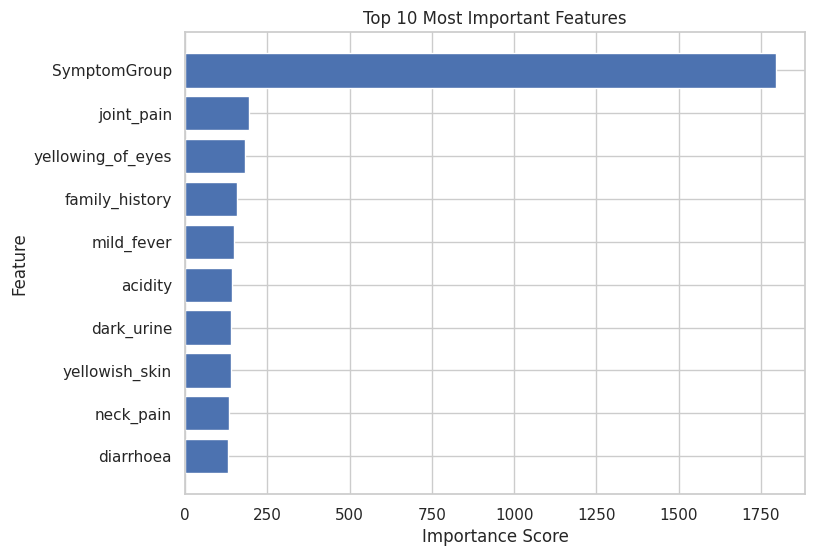

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert feature importances to DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': random_search.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


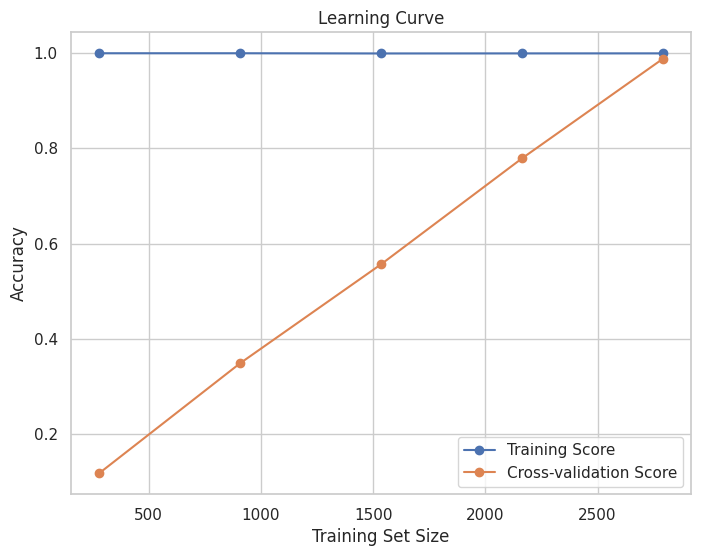

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    random_search.best_estimator_, X_train, y_train_encoded, cv=3, scoring='accuracy'
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


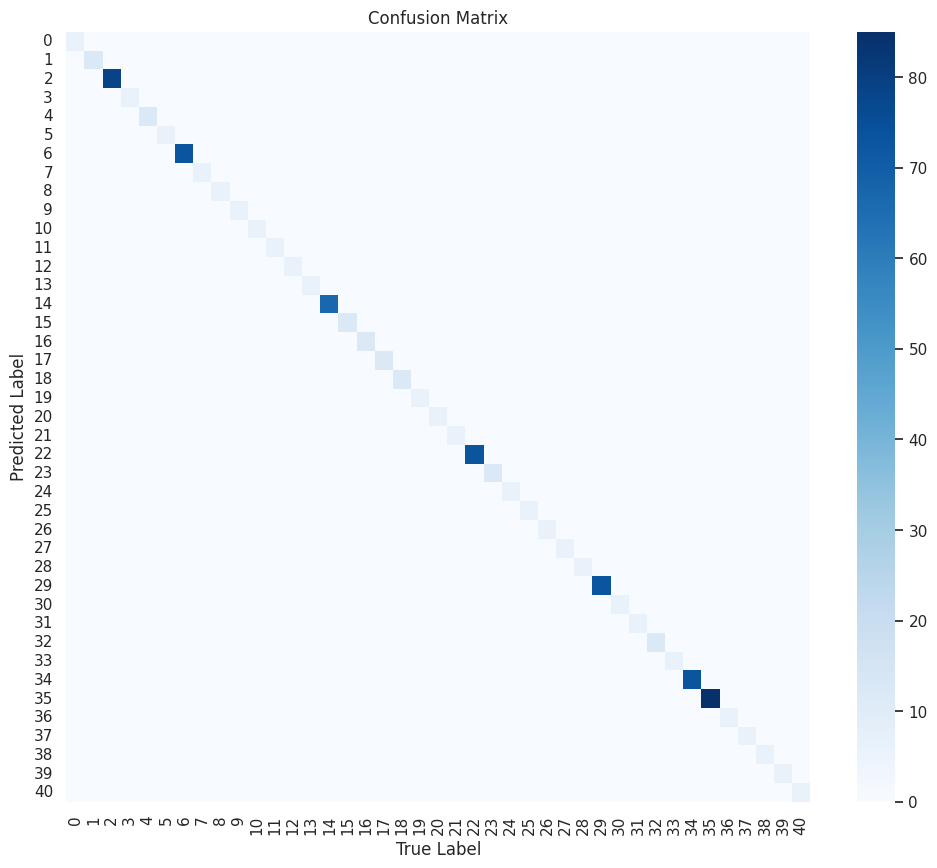

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat_ = confusion_matrix(y_test_encoded, y_pred)
labels_ = np.unique(y_test_encoded)

plt.figure(figsize=(12, 10))
sns.heatmap(mat_, annot=False, fmt='d', cmap='Blues',
            xticklabels=labels_, yticklabels=labels_)

plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Use the correct variable names from your current code
accuracy_ = accuracy_score(y_test_encoded, y_pred)  # ← FIXED: y_test_encoded and y_pred
print(f"Accuracy: {accuracy_:.4f}")  # ← Using .4f for better precision

Accuracy: 1.0000


**Merge DATASET**

In [ ]:
full_data = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
from sklearn.model_selection import train_test_split

X = full_data.drop(columns=['prognosis'])

y = full_data['prognosis']

y = y.astype('category')
y_encoded = y.cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')

Training set size: (3969, 132)
Testing set size: (993, 132)


In [ ]:
overlap = X_train.merge(X_test, how='inner')
print(f"Overlap rows: {len(overlap)}")

Overlap rows: 39824


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import pandas as pd
import time

# Complete models dictionary with all classifiers
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced')
}

# Define hyperparameter grids for ALL models
model_grids = {
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
     'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.3],  # Higher learning rate
        'max_depth': [3, 4]  # Shallower trees
    },
    'LightGBM': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.3],
        'num_leaves': [20, 31]  # Fewer leaves
    }
}

# Your evaluation function (improved)
def evaluate_model_with_gridsearch_classification(name, model, param_grid, X_train, y_train, X_test, y_test):
    """
    Evaluate a model with grid search for CLASSIFICATION problems
    """
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Fix for LogisticRegression convergence and scaling
    if name == 'LogisticRegression':
        model.max_iter = 5000  # Increase iterations
        # Scale data for Logistic Regression
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train_to_use = scaler.fit_transform(X_train)
        X_test_to_use = scaler.transform(X_test)
    else:
        X_train_to_use, X_test_to_use = X_train, X_test

    print(f"🔧 Tuning {name} with grid search...")

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Time the training
    start_time = time.time()
    grid_search.fit(X_train_to_use, y_train)
    training_time = time.time() - start_time

    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions
    y_pred = best_model.predict(X_test_to_use)

    # Calculate CLASSIFICATION metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"✅ {name} Best CV Score: {grid_search.best_score_:.4f}")
    print(f"   Best Parameters: {best_params}")
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   Training Time: {training_time:.2f}s")
    print("-" * 50)

    return {
        'model': best_model,
        'params': best_params,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'best_cv_score': grid_search.best_score_,
        'time': training_time
    }

# Run grid search for all models
results = {}
for name in models.keys():
    results[name] = evaluate_model_with_gridsearch_classification(
        name,
        models[name],
        model_grids[name],
        X_train, y_train, X_test, y_test  # Make sure these are defined in your environment
    )

# Comparison (after running all models)
print("\n📊 QUICK COMPARISON:")
print("=" * 50)
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1_score'],
        'Training Time (s)': result['time']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Accuracy', ascending=False)
display(comparison_df)

# Winner
best_model = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']
print(f"\n🏆 QUICK WINNER: {best_model} with {best_accuracy:.4f} accuracy!")

🔧 Tuning LogisticRegression with grid search...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ LogisticRegression Best CV Score: 0.9997
   Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
   Test Accuracy: 1.0000
   Training Time: 50.13s
--------------------------------------------------
🔧 Tuning RandomForest with grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ RandomForest Best CV Score: 0.9997
   Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
   Test Accuracy: 1.0000
   Training Time: 27.01s
--------------------------------------------------
🔧 Tuning XGBoost with grid search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ XGBoost Best CV Score: 0.9995
   Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
   Test Accuracy: 1.0000
   Training Time: 68.21s
--------------------------------------------------
🔧 Tuning LightGBM with grid search...
Fitting 5 folds for eac

,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s)
0,LogisticRegression,1.0,1.0,1.0,1.0,50.134814
1,RandomForest,1.0,1.0,1.0,1.0,27.010447
2,XGBoost,1.0,1.0,1.0,1.0,68.207017
3,LightGBM,1.0,1.0,1.0,1.0,51.923993



🏆 QUICK WINNER: LogisticRegression with 1.0000 accuracy!


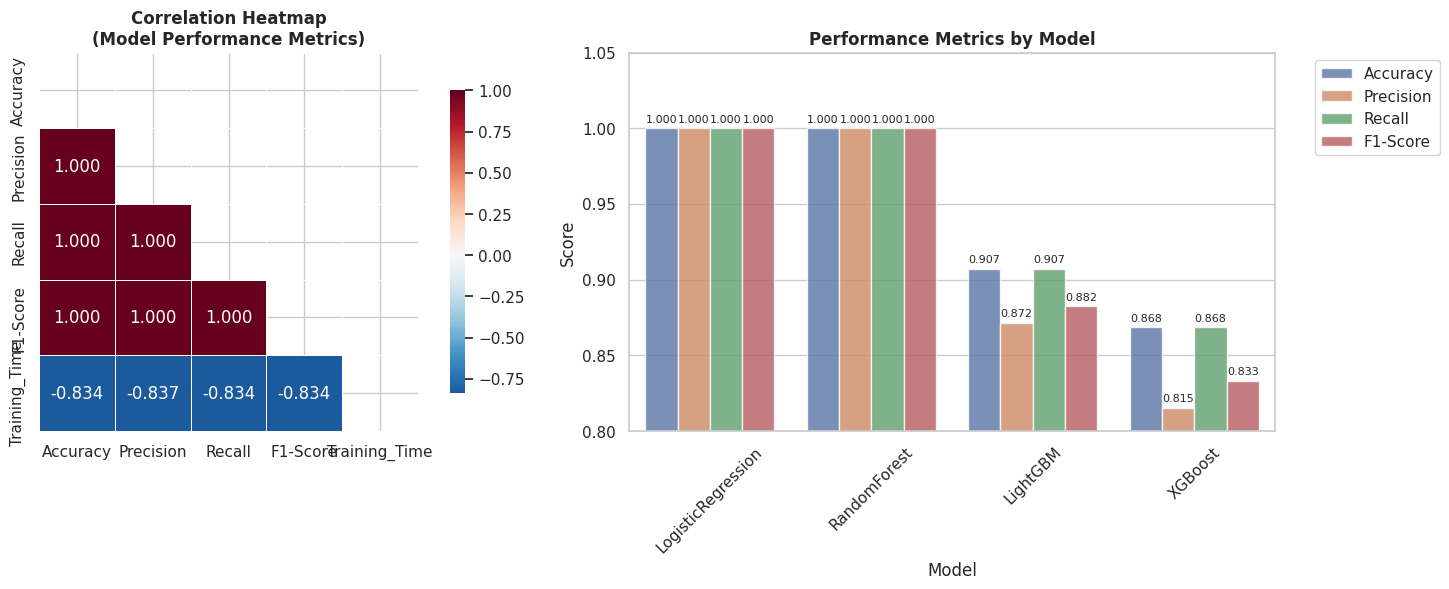

🔍 CORRELATION INSIGHTS:
Accuracy vs Precision: 1.000 (Very Strong)
Accuracy vs Recall: 1.000 (Perfect)
Accuracy vs F1-Score: 1.000 (Very Strong)
Accuracy vs Training_Time: -0.834 (Moderate)
Precision vs Recall: 1.000 (Very Strong)
Precision vs F1-Score: 1.000 (Very Strong)
Precision vs Training_Time: -0.837 (Moderate)
Recall vs F1-Score: 1.000 (Very Strong)
Recall vs Training_Time: -0.834 (Moderate)
F1-Score vs Training_Time: -0.834 (Moderate)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Your data
data = {
    'Model': ['LogisticRegression', 'RandomForest', 'LightGBM', 'XGBoost'],
    'Accuracy': [1.000000, 1.000000, 0.907097, 0.868387],
    'Precision': [1.000000, 1.000000, 0.871604, 0.815464],
    'Recall': [1.000000, 1.000000, 0.907097, 0.868387],
    'F1-Score': [1.000000, 1.000000, 0.882488, 0.833285],
    'Training_Time': [45.069467, 26.007909, 46.482586, 70.974450]
}

df = pd.DataFrame(data)
df_numeric = df.set_index('Model')

# Create a more comprehensive visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Correlation Heatmap
corr_matrix = df_numeric.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax1)
ax1.set_title('Correlation Heatmap\n(Model Performance Metrics)', fontsize=12, fontweight='bold')

# 2. Performance Metrics Comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_melted = df.melt(id_vars=['Model'], value_vars=metrics_to_plot,
                    var_name='Metric', value_name='Score')

sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', ax=ax2, alpha=0.8)
ax2.set_title('Performance Metrics by Model', fontsize=12, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_ylim(0.8, 1.05)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', padding=3, fontsize=8)

plt.tight_layout()
plt.show()

# Print correlation insights
print("🔍 CORRELATION INSIGHTS:")
print("=" * 40)
for i, col1 in enumerate(corr_matrix.columns):
    for j, col2 in enumerate(corr_matrix.columns):
        if i < j:  # Only show upper triangle
            corr_value = corr_matrix.iloc[i, j]
            interpretation = "Perfect" if corr_value == 1.0 else "Very Strong" if corr_value > 0.9 else "Strong" if corr_value > 0.7 else "Moderate"
            print(f"{col1} vs {col2}: {corr_value:.3f} ({interpretation})")